In [2]:
%reload_ext autoreload
%autoreload 2

import my_tools as tools

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import t
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats
from scipy.linalg import sqrtm
from numpy.linalg import inv
from IPython.display import display

In [3]:
eps = 0.01
alpha = 0.1
steps = 1000

In [119]:
def gradient_descent(X, y, W, int_, alpha):
    n = X.shape[1]
    y_pred = np.sum(np.multiply(W, X), axis = 0) + int_
    # y_pred = np.sum(np.multiply(W, X)) + int_
    error = y_pred - y
    
    W_d = (1/n) * np.dot(X, error)[:, None]
    int_d = (1/n) * np.sum(error)
    
    new_W = W - alpha * W_d
    new_int_ = int_ - np.sum(alpha * int_d)

    return new_W, new_int_

def my_fit(X, y):
    X_rows = X.T
    int_ = 0
    W = np.zeros((len(X_rows), 1))
    STD = np.std(X_rows, axis=1, keepdims=True)
    MEAN = np.mean(X_rows, axis=1, keepdims=True)
    X_scaled = np.divide((X_rows - MEAN), STD)

    
    W_history = []
    int_history = []
    
    for step in range(steps):
        W_new, int_new = gradient_descent(X_scaled, y, W, int_, alpha)
        W_history.append(W_new)
        int_history.append(int_new)

        if (abs(W_new - W)<eps).any() and abs(int_new - int_) < eps:
            break
            
        W, int_ = (W_new, int_new)
    W_orig = np.divide(W, STD).flatten()
    int_orig = int_ - np.divide(np.multiply(W, MEAN), STD).sum()
    
    return (W_orig, int_orig, W_history, int_history)

In [ ]:
def get_regression_stats(X, y, int_=True):
    df = X.shape[1] + 1
    if int_ is True:
        X2 = np.insert(X, 0, 1, axis=1)
    else:
        X2 = X    
    X_T = X2.T
    X_inv = inv(np.matmul(X2.T, X2))

    B = np.matmul(np.matmul(X_inv, X_T), y)[:, None]
    y_pred = np.sum(np.multiply(B, X_T), axis = 0)
    
    stats_df = pd.DataFrame()
    meta_stats_df = pd.DataFrame()
    
    names = ['RSE', 'R^2', 'Adj R^2', 'F-value']
    meta_stats_df['names'] = names
    meta_stats_df = meta_stats_df.set_index('names')
    
    names = [f"b{i}" for i in range(B.shape[0])]
    stats_df['names'] = names
    stats_df = stats_df.set_index('names')
    stats_df['coef'] = B
    ### Coefficient Statistics
    
    STD = tools.RSS(y, y_pred, df)
    RSE = tools.RSE(y, y_pred, df)
    R_sq = tools.R_sq(y, y_pred)
    R_sq_adj = tools.R_sq_adj(y, y_pred, df)
    cov_mat = STD * X_inv
    SE = np.sqrt(np.diag(cov_mat))[:, None]
    stats_df['Std. err.'] = SE.flatten()

    T = np.divide(B, SE)
    stats_df['t-stat'] = T.flatten()

    F = tools.F_stat(y, y_pred, df)
    
    P = 2 * t.sf(np.abs(T), X.shape[0]-df)
    stats_df['p-value'] = P.flatten()

    conf_int_low = []
    conf_int_high = []
    for i in range(len(B)):
        low = B[i] - 1.97 * SE[i]
        high = B[i] + 1.97 * SE[i]
        conf_int_low.append(low[0])
        conf_int_high.append(high[0])
    stats_df['2.5%'] = conf_int_low
    stats_df['97.5%'] = conf_int_high

    ### Meta-Statistics
    meta_values = [RSE, R_sq, R_sq_adj, F]
    meta_stats_df['values'] = meta_values

    return stats_df, meta_stats_df

In [5]:
def get_prediction(X, coef_):
    return np.sum(np.multiply(coef_, X), axis = 0)[0]

In [6]:
def get_prediction_interval(y, y_pred, X, X_new, coef_):
    y_new = get_prediction(X_new, coef_)
    RSE = tools.RSE(y, y_pred, coef_.shape[0])
    SE_sq = (RSE**2) * np.matmul(np.matmul(X_new.T, inv(np.matmul(X.T, X))), X_new)
    # print(X_new.T.shape, inv(np.matmul(X.T, X)).shape, X_new.shape)
    y_low = y_new - 1.972 * np.sqrt(SE_sq + RSE**2)
    y_high = y_new + 1.972 * np.sqrt(SE_sq + RSE**2)
    # print(y_low.shape, y_high.shape)
    return (y_low.flatten(), y_high.flatten())

# Multiple Linear Regression With Gradient Descent (My Implementation)

In [5]:
df = pd.read_csv('advertising.csv')

In [6]:
X = df[['TV', 'Radio', 'Newspaper']].values
# X = df[['TV',]].values
y = df['Sales'].values

In [7]:
W, int_, W_history, int_history = my_fit(X, y)
print(W)
print(int_)
print(len(int_history))

[0.05409607 0.10503128 0.0019755 ]
4.5760012809512745
49


In [8]:
X_rows = X.T
W = np.zeros(len(X_rows))
STD = np.std(X_rows, axis=1)
MEAN = np.mean(X_rows, axis=1, keepdims=True)
print(MEAN.shape)

(3, 1)


In [9]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     605.4
Date:                Wed, 18 Feb 2026   Prob (F-statistic):           8.13e-99
Time:                        20:04:58   Log-Likelihood:                -383.34
No. Observations:                 200   AIC:                             774.7
Df Residuals:                     196   BIC:                             787.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6251      0.308     15.041      0.0

# Multiple Linear Regression With Matrix Formula

In [126]:
df = pd.read_csv('advertising.csv')

In [65]:
# X = df[['TV', 'Radio', 'Newspaper']].values
X = df[['TV']].values
y = df['Sales'].values
print(X.shape[1])

1


In [66]:
stats, meta = get_regression_stats(X, y)
display(stats)
display(meta)

,coef,Std. err.,t-stat,p-value,2.5%,97.5%
names,,,,,,
b0,6.974821,0.322553,21.623767,5.027719e-54,6.339391,7.610252
b1,0.055465,0.001896,29.260497,7.927912e-74,0.051731,0.059199


,values
names,
RSE,2.295746
R^2,0.812176
Adj R^2,0.811227
F-value,850.905829


In [342]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(type(est))
print(est2.summary())

<class 'statsmodels.regression.linear_model.OLS'>
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     306.9
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           8.91e-74
Time:                        17:07:38   Log-Likelihood:                -442.21
No. Observations:                 200   AIC:                             892.4
Df Residuals:                     196   BIC:                             905.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [85]:

print(get_prediction_interval(y, y_pred, X2, X_new, B))
#print(get_prediction_interval(y, y_pred, X2, X_new, B))
print(prediction_obj.conf_int(alpha=0.05))

(array([9.38952391]), array([16.0389909]))
[[12.1520581 13.2764567]]


In [55]:
X_new = [1, 50, 50, 50]
prediction_obj = est2.get_prediction(X_new)
frame = prediction_obj.summary_frame(alpha=0.05)
lower_pi = frame['obs_ci_lower']
upper_pi = frame['obs_ci_upper']
print(lower_pi.values)
print(upper_pi.values)

[9.38928582]
[16.03922899]


# Multiple Linear Regression - Log Function

In [4]:
df = pd.read_csv('advertising.csv')

In [5]:

X = df[['TV']]
y = df['Sales']

In [6]:
X_old = df['TV'].values
X['TVlog'] = np.log(X['TV'] + 20)
X['TVexp'] = 1.005**(X['TV'])

In [7]:
X['final'] = X['TVlog'] + X['TVexp']

In [8]:
X['final'] = np.sqrt(X_old)

In [9]:
F = X['final'].values[:, None]

In [15]:
W, int_, W_hist, int_hist = tools.my_fit(F, y)

In [16]:
print(int_, W)

1.9164050238924553 [1.15044339]


In [17]:
df_s, df_m = tools.get_regression_stats(F, y)

In [24]:
X2 = sm.add_constant(F)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              2537.
Date:                Sat, 21 Feb 2026   Prob (F-statistic):                   1.52e-167
Time:                        17:53:32   Log-Likelihood:                         -441.96
No. Observations:                 200   AIC:                                      891.9
Df Residuals:                     196   BIC:                                      905.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [18]:
display(df_s)
display(df_m)

,coef,Std. err.,t-stat,p-value,2.5%,97.5%
names,,,,,,
b0,1.928677,0.464826,4.149246,4.950029e-05,1.012970,2.844384
b1,1.157810,0.038333,30.204283,4.640347e-76,1.082295,1.233325


,values
names,
RSE,2.236972
R^2,0.822561
Adj R^2,0.821665
F-value,912.298714


In [19]:
y_pred = (np.multiply(W, X['final'].T) + int_)
X_old = X_old.flatten()

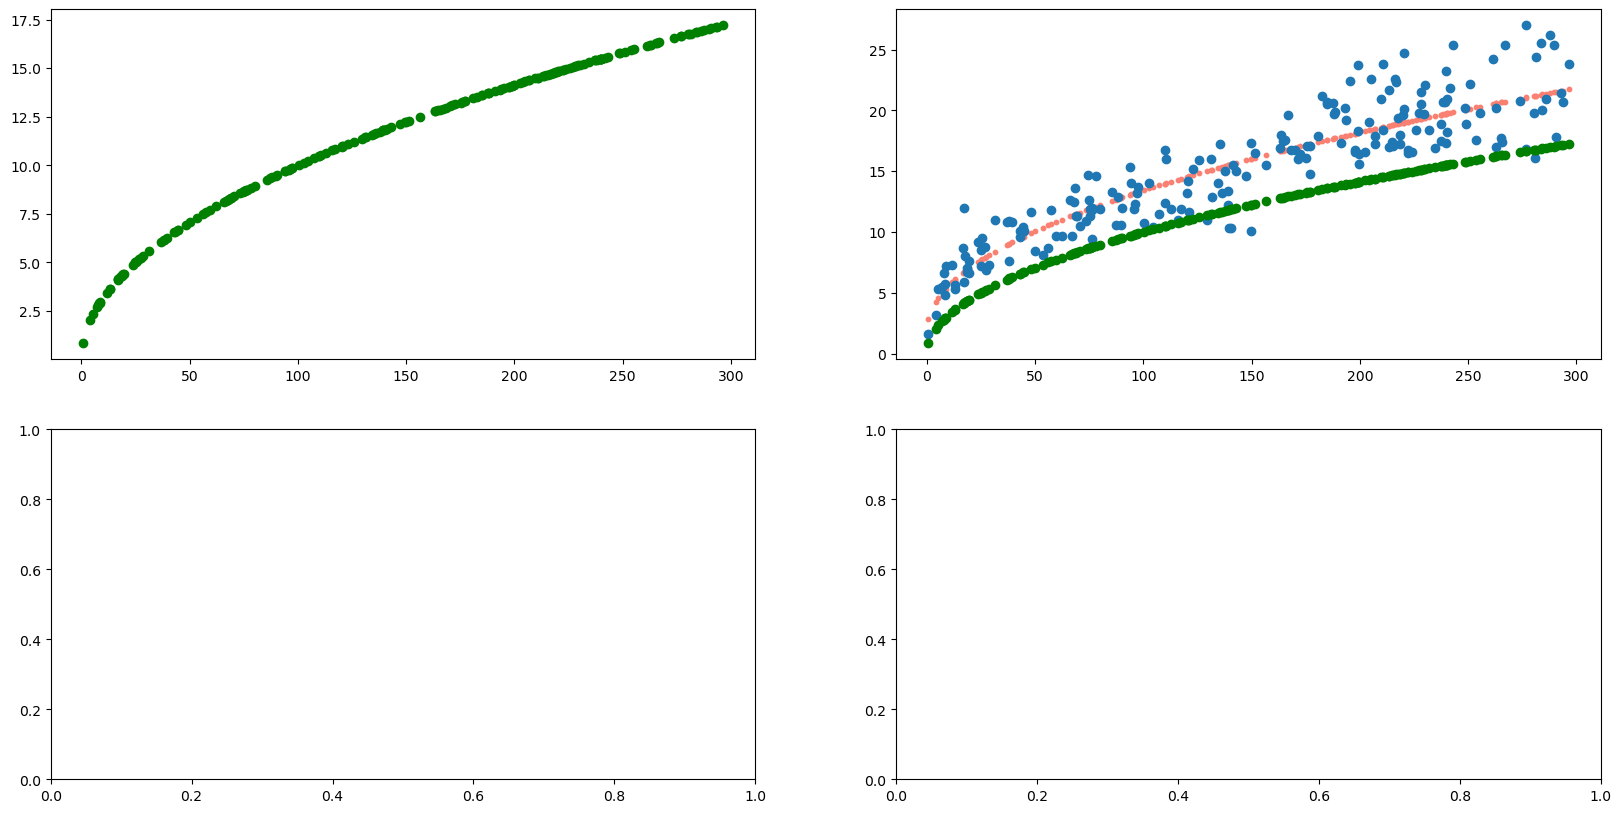

In [20]:
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(20, 10))

axs[0, 1].scatter(X_old.flatten(), y_pred, s=10, color='salmon')
axs[0, 1].scatter(x=df['TV'], y=df['Sales'])
axs[0, 1].scatter(x=X['TV'], y=X['final'].values, color='green')

axs[0, 0].scatter(x=X['TV'], y=X['final'].values, color='green')
